In [24]:
from pathlib import Path
import matplotlib.pyplot as plt

from ray.tune import ExperimentAnalysis
import json
from pathlib import Path

import os
import pandas as pd

This gives errors <br>
config_path = os.path.abspath("config.json")
with open("config.json", "w") as f:
    json.dump(config, f)

script_path = os.path.abspath("scr/run_hypertune.py")
env = os.environ.copy()
env["PYTHONPATH"] = os.path.abspath(".")

result = subprocess.run([sys.executable, script_path, config_path],
                        capture_output= True,
                        text= True,
                        env= env
        )

print("Returncode:", result.returncode)
print("Output:", result.stdout)
print("Error:", result.stderr)

So
1. change json file with notebook
2. run in terminal python scr\\run_hypertune.py config.json

In [7]:
# test config
config = {
    "filters": 8,
    "units1": 16,
    "units2": 8,
    "dropout_dense_rate": 0.1,
    "dropout_conv_rate": 0.0,
    "use_batchnorm": False,
    "use_maxpooling": False,
    "num_blocks": 1,
    "lr": 0.0005,
    "num_classes": 2,
    "epochs": 20,
    "patience": 3
}


### Functies visualisaties

In [ ]:
def plot_trials_separately_with_equal_axes(experiment_dir):
    trial_dirs = [
        os.path.join(experiment_dir, d)
        for d in os.listdir(experiment_dir)
        if os.path.isdir(os.path.join(experiment_dir, d))
    ]

    max_epoch = 0
    min_acc = 1.0
    max_acc = 0.0

    dfs = []
    valid_trial_dirs = []

    for trial_dir in trial_dirs:
        csv_path = os.path.join(trial_dir, "progress.csv")
        if not os.path.exists(csv_path):
            print(f"Geen progress.csv in {trial_dir}")
            continue

        df = pd.read_csv(csv_path)
        if 'val_accuracy' not in df.columns or 'train_accuracy' not in df.columns:
            print(f"Train/val accuracy niet gevonden in {csv_path}")
            continue

        # Epochs bepalen
        epochs = df['epoch'] if 'epoch' in df.columns else pd.Series(range(len(df)))

        max_epoch = max(max_epoch, epochs.max())
        min_acc = min(min_acc, df[['train_accuracy', 'val_accuracy']].min().min())
        max_acc = max(max_acc, df[['train_accuracy', 'val_accuracy']].max().max())

        dfs.append((df, trial_dir, epochs))
        valid_trial_dirs.append(trial_dir)

    num_trials = len(dfs)
    if num_trials == 0:
        print("Geen geldige trials gevonden.")
        return

    cols = 2
    rows = (num_trials + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows), squeeze=False)

    best_val = 0
    best_trial = None

    for i, (df, trial_dir, epochs) in enumerate(dfs):
        ax = axes[i // cols][i % cols]

        ax.plot(epochs, df['train_accuracy'], label='Train Accuracy', alpha=0.6)
        ax.plot(epochs, df['val_accuracy'], label='Val Accuracy')
        
        best_val_score = df['val_accuracy'].max()
        ax.set_title(f"Trial {os.path.basename(trial_dir)}\nBest val_acc: {best_val_score:.4f}")

        ax.set_xlabel("Epoch")
        ax.set_ylabel("Accuracy")
        ax.set_xlim(0, max_epoch)
        ax.set_ylim(min_acc - 0.05, max_acc + 0.05)  
        ax.grid(True)
        ax.legend(fontsize='small')

        if best_val_score > best_val:
            best_val = best_val_score
            best_trial = trial_dir

    for j in range(num_trials, rows * cols):
        fig.delaxes(axes[j // cols][j % cols])

    plt.tight_layout()
    plt.show()

    print(f"Beste trial: {best_trial} met val_accuracy = {best_val:.4f}")

## Start Experiments
#### trail 12-54-12
Adding more blocks (num_blocks=4) in combination with batch norm and maxpooling will make the validation results for complex data more accurate than with models without batch norm and maxpooling and with fewer blocks.

In [3]:
config = {
    "filters": {"choice": [16, 32, 64]},
    "units1": {"choice": [64]},
    "units2": {"choice": [32]},
    "dropout_dense_rate": 0.0,
    "dropout_conv_rate": 0.0,
    "use_batchnorm": {"choice": [True, False]},
    "use_maxpooling": {"choice": [True, False]},
    "num_blocks": {"choice": [2, 3, 4]},
    "lr": 1e-2,
    "num_classes": 2,
    "epochs": 20,
    "patience": 3
}

with open("config.json", "w") as f:
    json.dump(config, f)


##### Resultaten

In [ ]:
results_dir = Path("..") / "4-hypertuning-ray" / "ray_results" / "train_ray_2025-10-19_12-54-12"
print(str(results_dir.resolve()))

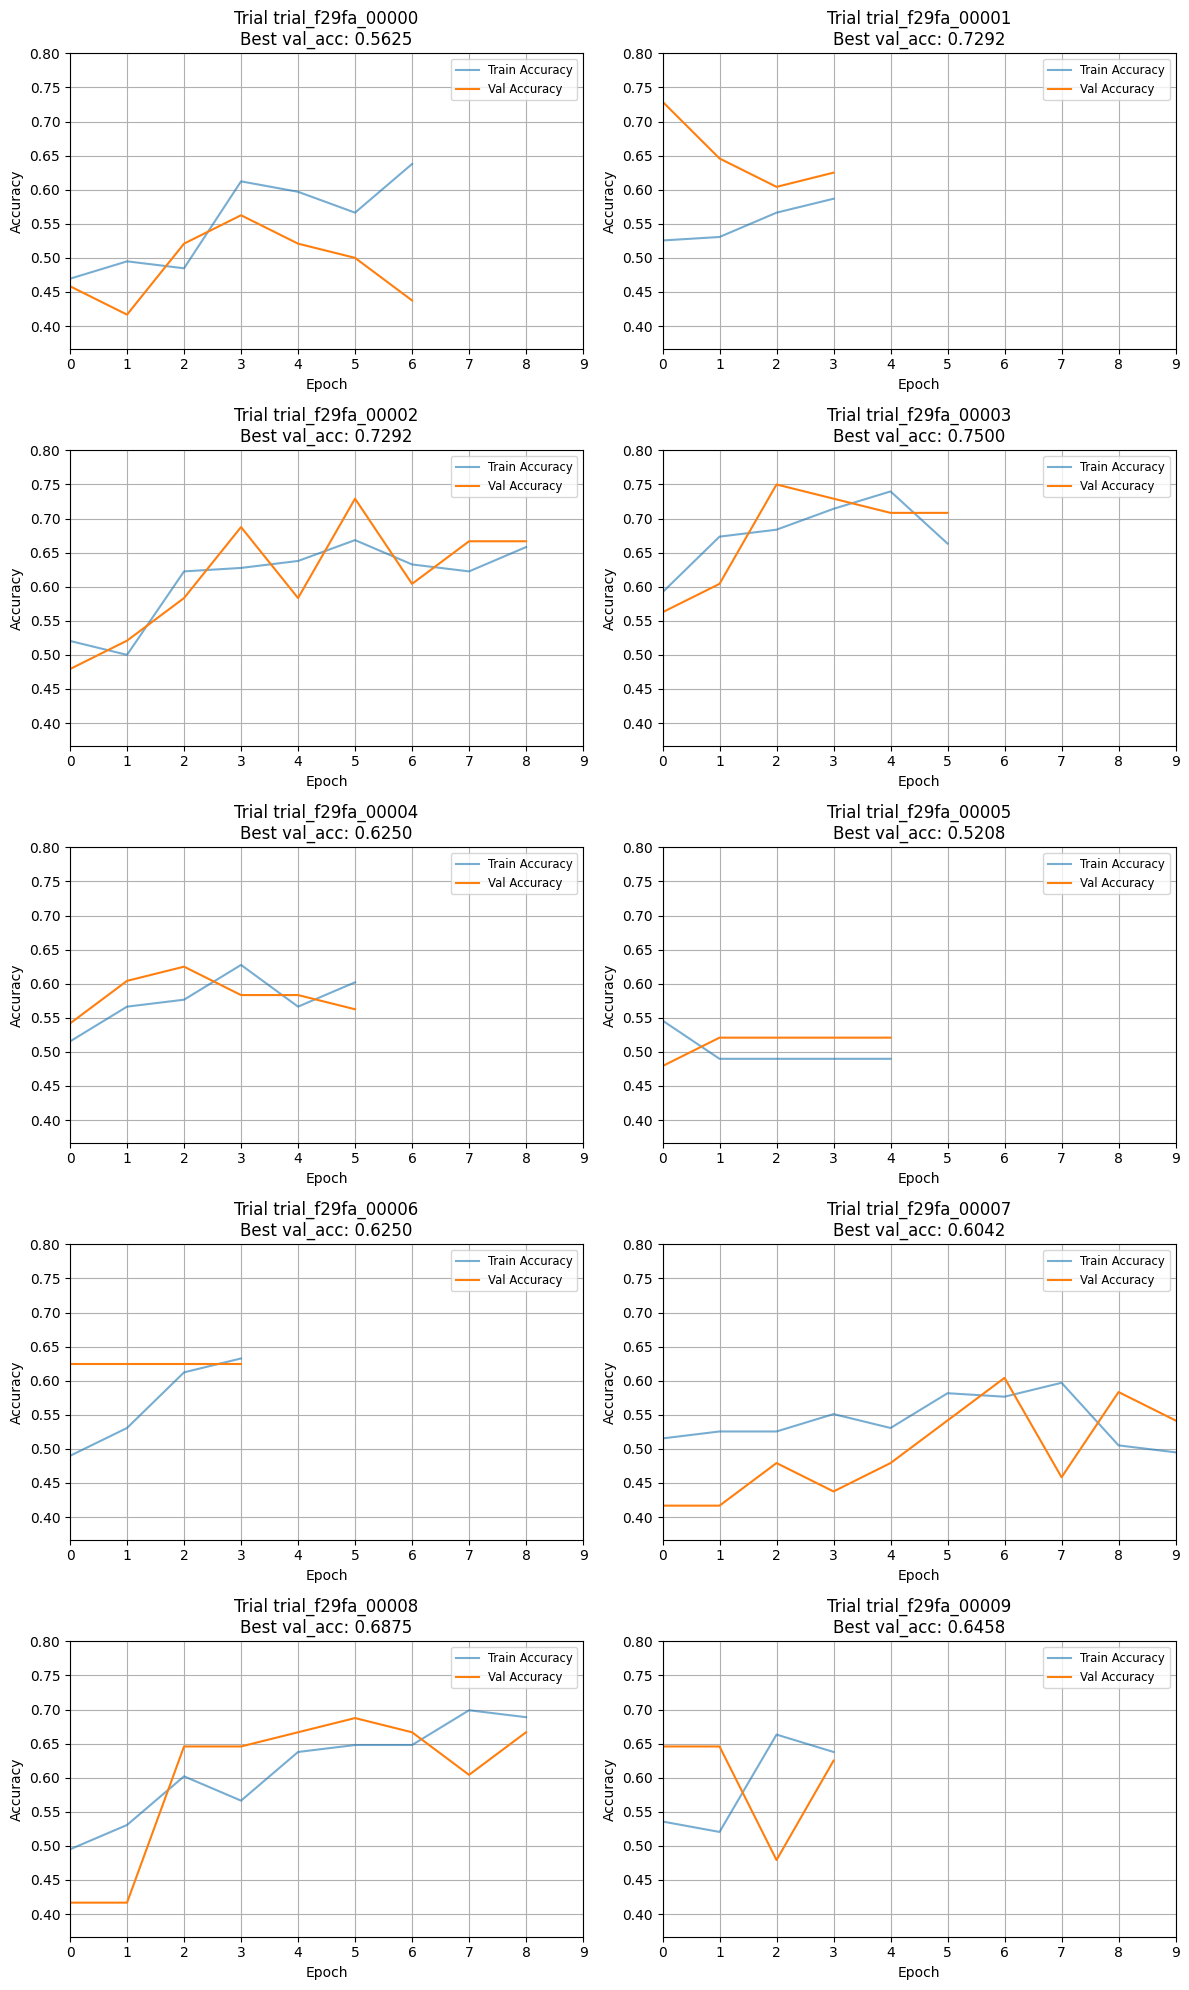

Beste trial: ..\4-hypertuning-ray\ray_results\train_ray_2025-10-19_12-54-12\trial_f29fa_00003 met val_accuracy = 0.7500


In [ ]:
experiment_dir = results_dir
plot_trials_separately_with_equal_axes(experiment_dir)


In [ ]:
analysis = ExperimentAnalysis(str(results_dir.resolve()))

df = analysis.dataframe()
filtered_df = df[df["logdir"] == "f29fa_00001"]
if not filtered_df.empty:
    row = filtered_df.iloc[0]  # pak eerste (en enige) rij als Series
    for col, val in row.items():
        print(f"{col}: {val}")
else:
    print("Geen rijen gevonden met die logdir")

C:\Users\pikob\Documents\GitHub\portfolio-MADS-ML-ElinevDijk\4-hypertuning-ray\ray_results\train_ray_2025-10-19_12-54-12
patience: 3
Max_epochs: 20
train_loss: 0.6557993548257011
train_accuracy: 0.5867346938775511
val_loss: 0.5927929679552714
val_accuracy: 0.625
timestamp: 1760871297
checkpoint_dir_name: None
done: False
training_iteration: 4
trial_id: f29fa_00001
date: 2025-10-19_12-54-57
time_this_iter_s: 7.808140993118286
time_total_s: 32.73649454116821
pid: 12156
hostname: LAPTOP-SHCS6ICM
node_ip: 127.0.0.1
time_since_restore: 32.73649454116821
iterations_since_restore: 4
config/filters: 64
config/units1: 64
config/units2: 32
config/dropout_dense_rate: 0.0
config/dropout_conv_rate: 0.0
config/use_batchnorm: False
config/use_maxpooling: True
config/num_blocks: 2
config/lr: 0.01
config/num_classes: 2
config/epochs: 20
config/patience: 3
logdir: f29fa_00001


Uit de resultaten blijkt duidelijk dat de situaties met maxpooling betere scoren. verder is er slechts 1 keer getest met 4 blocks en toen stond maxpooling uit hierdoor kan er nog geen duidelijke conclusie worden getrokken over het aantal blocks dus nog meer experimenten met de volgende config

#### train 14-23-13

In [23]:
config = {
    "filters": {"choice": [16, 32, 64]},
    "units1": {"choice": [64]},
    "units2": {"choice": [32]},
    "dropout_dense_rate": 0.0,
    "dropout_conv_rate": 0.0,
    "use_batchnorm": {"choice": [True, False]},
    "use_maxpooling": True,
    "num_blocks": {"choice": [2, 3, 4, 5]},
    "lr": 1e-2,
    "num_classes": 2,
    "epochs": 20,
    "patience": 3
}

with open("config.json", "w") as f:
    json.dump(config, f)


##### Results

In [27]:
results_dir = Path("..") / "4-hypertuning-ray" / "ray_results" / "train_ray_2025-10-19_14-23-13"

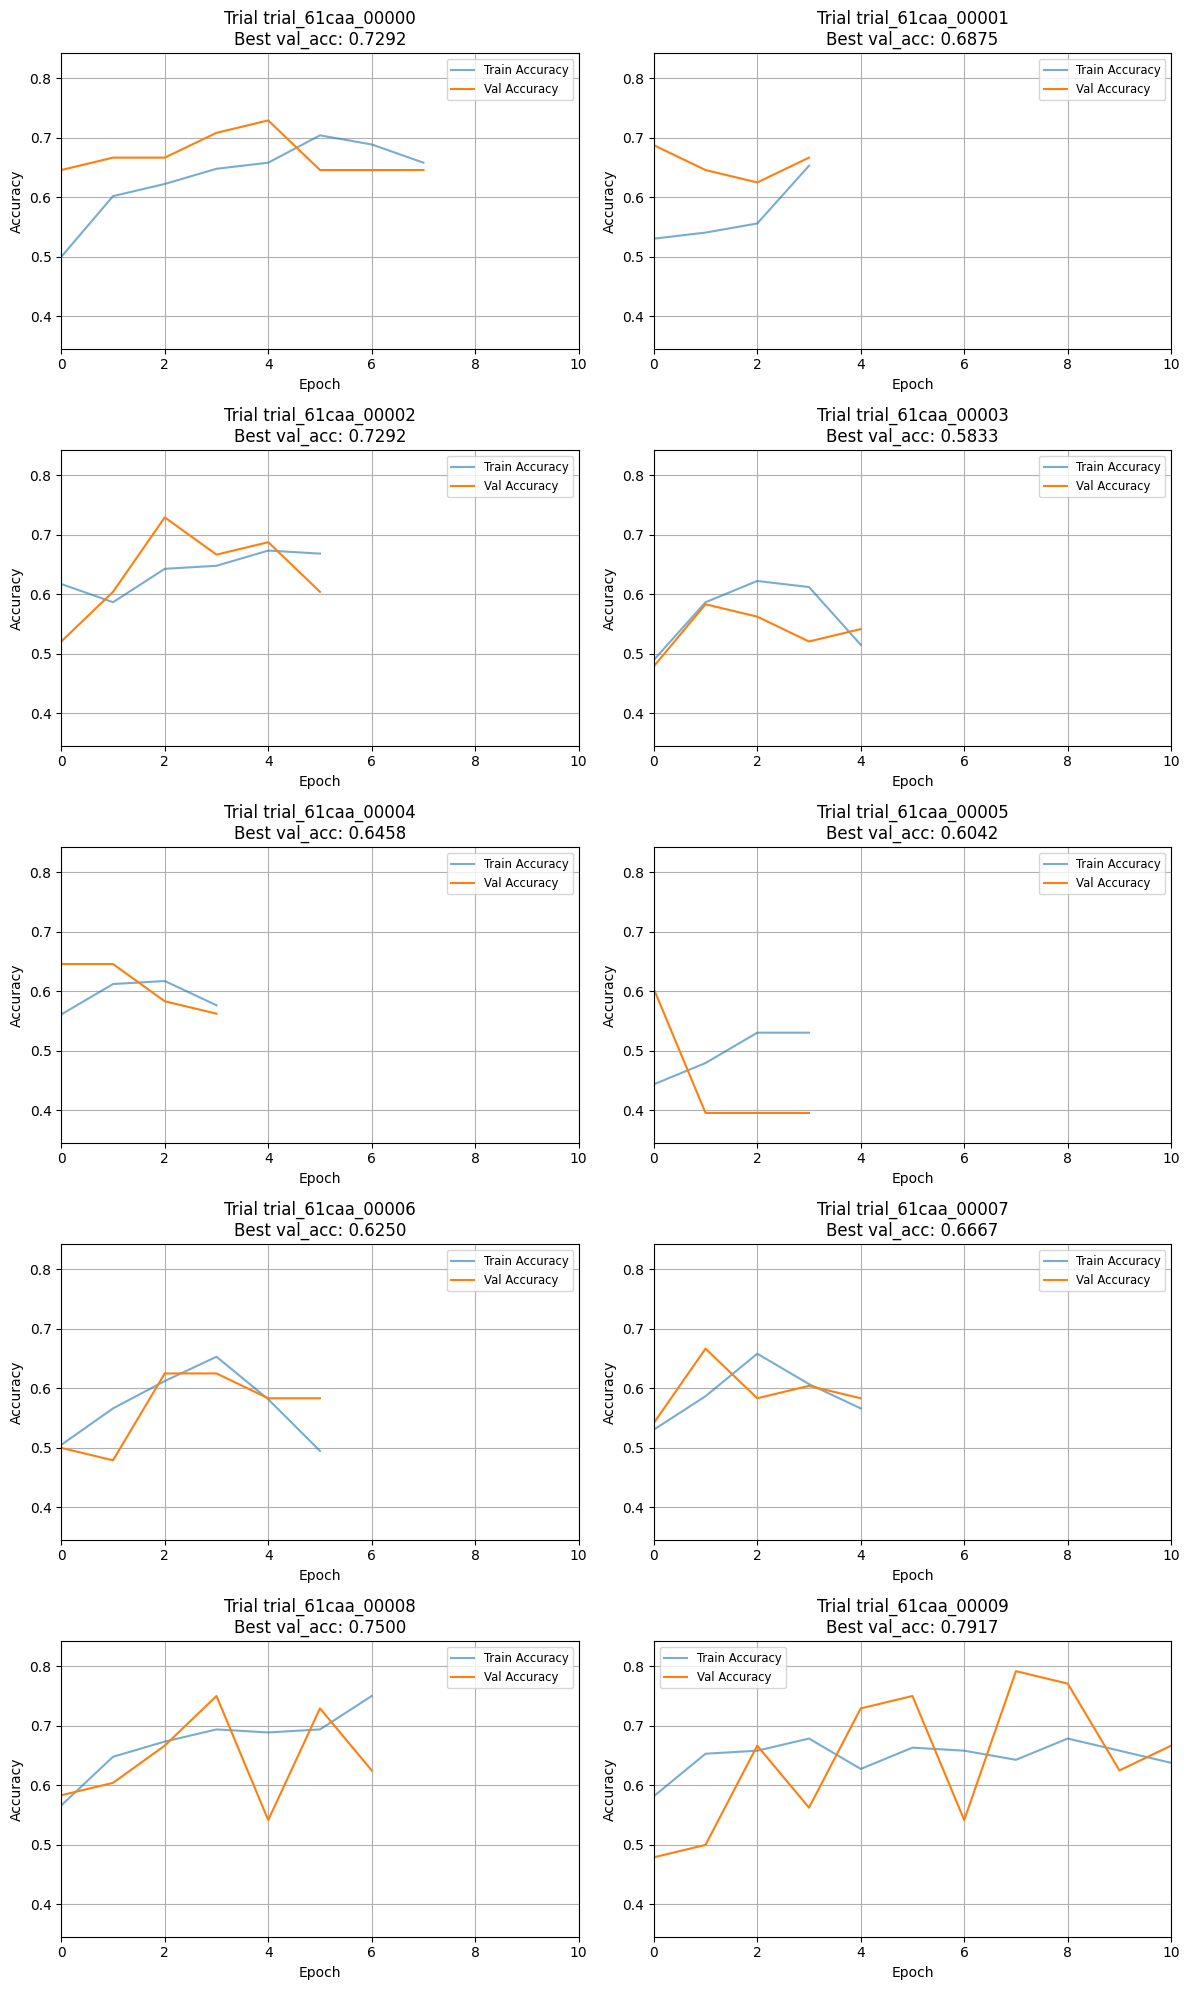

Beste trial: ..\4-hypertuning-ray\ray_results\train_ray_2025-10-19_14-23-13\trial_61caa_00009 met val_accuracy = 0.7917


In [28]:
experiment_dir = results_dir
plot_trials_separately_with_equal_axes(experiment_dir)

In [30]:
analysis = ExperimentAnalysis(str(results_dir.resolve()))

df = analysis.dataframe()
filtered_df = df[df["logdir"] == "61caa_00009"]
if not filtered_df.empty:
    row = filtered_df.iloc[0]  # pak eerste (en enige) rij als Series
    for col, val in row.items():
        print(f"{col}: {val}")
else:
    print("Geen rijen gevonden met die logdir")

patience: 3
Max_epochs: 20
train_loss: 0.6441783357639702
train_accuracy: 0.6377551020408163
val_loss: 0.6509560147921244
val_accuracy: 0.6666666666666666
timestamp: 1760876745
checkpoint_dir_name: None
done: False
training_iteration: 11
trial_id: 61caa_00009
date: 2025-10-19_14-25-45
time_this_iter_s: 3.960927724838257
time_total_s: 50.79228186607361
pid: 7332
hostname: LAPTOP-SHCS6ICM
node_ip: 127.0.0.1
time_since_restore: 50.79228186607361
iterations_since_restore: 11
config/filters: 32
config/units1: 64
config/units2: 32
config/dropout_dense_rate: 0.0
config/dropout_conv_rate: 0.0
config/use_batchnorm: True
config/use_maxpooling: True
config/num_blocks: 3
config/lr: 0.01
config/num_classes: 2
config/epochs: 20
config/patience: 3
logdir: 61caa_00009


toch nog een iets lagere learning rate, want de grafieken stoppen erg snel 
#### train 14-41-14 and 14-49-32

In [48]:
config = {
    "filters": {"choice": [16, 32, 64]},
    "units1": {"choice": [64]},
    "units2": {"choice": [32]},
    "dropout_dense_rate": 0.0,
    "dropout_conv_rate": 0.0,
    "use_batchnorm": {"choice": [True, False]},
    "use_maxpooling": True,
    "num_blocks": {"choice": [2, 3, 4, 5]},
    "lr": 1e-3,
    "num_classes": 2,
    "epochs": 20,
    "patience": 3
}

with open("config.json", "w") as f:
    json.dump(config, f)


##### Results

In [34]:
results_dir = Path("..") / "4-hypertuning-ray" / "ray_results" / "train_ray_2025-10-19_14-41-14"

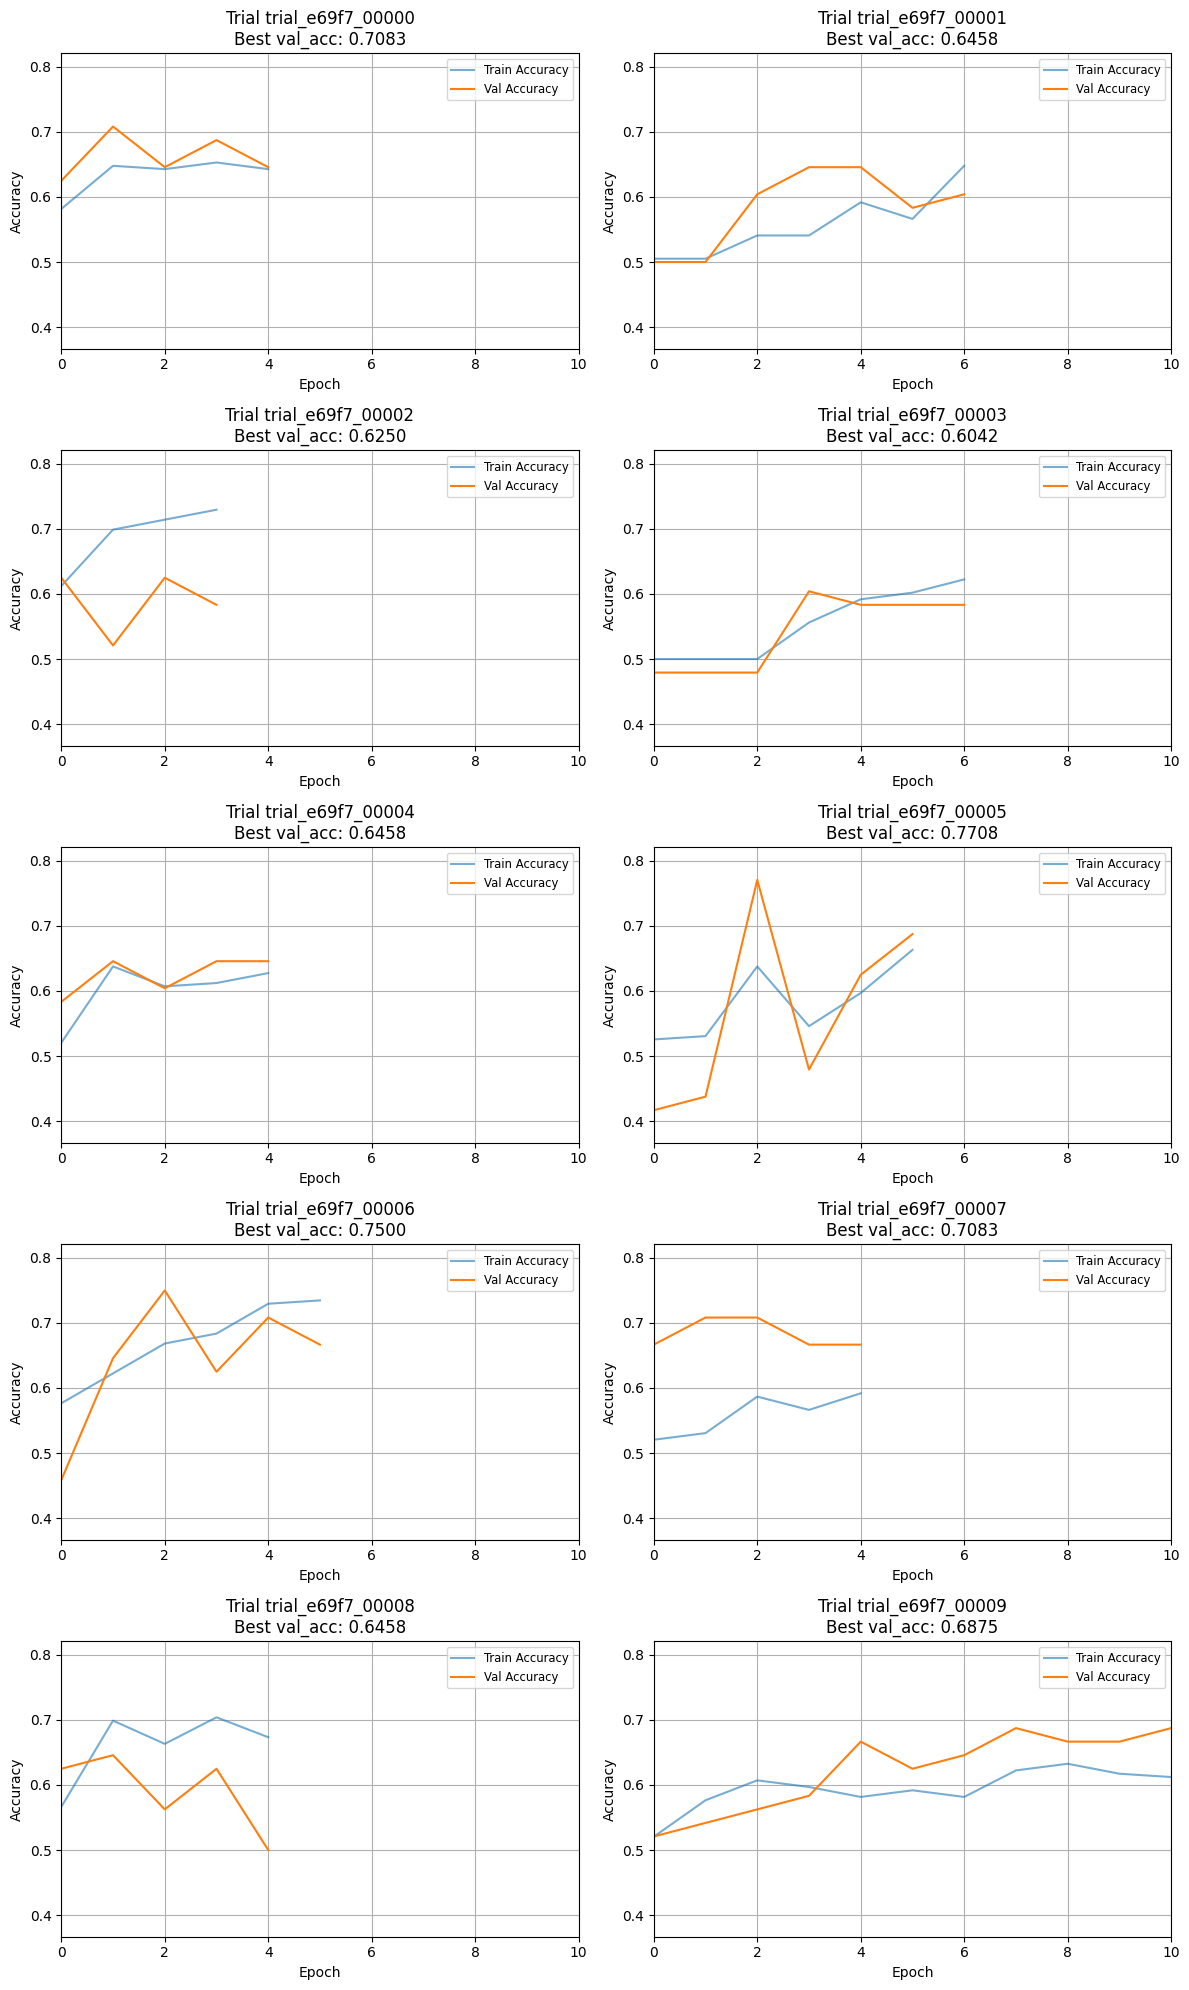

Beste trial: ..\4-hypertuning-ray\ray_results\train_ray_2025-10-19_14-41-14\trial_e69f7_00005 met val_accuracy = 0.7708


In [35]:
experiment_dir = results_dir
plot_trials_separately_with_equal_axes(experiment_dir)

In [ ]:
analysis = ExperimentAnalysis(str(results_dir.resolve()))

df = analysis.dataframe()
filtered_df = df[df["logdir"] == "61caa_00009"]
if not filtered_df.empty:
    row = filtered_df.iloc[0]  # pak eerste (en enige) rij als Series
    for col, val in row.items():
        print(f"{col}: {val}")
else:
    print("Geen rijen gevonden met die logdir")

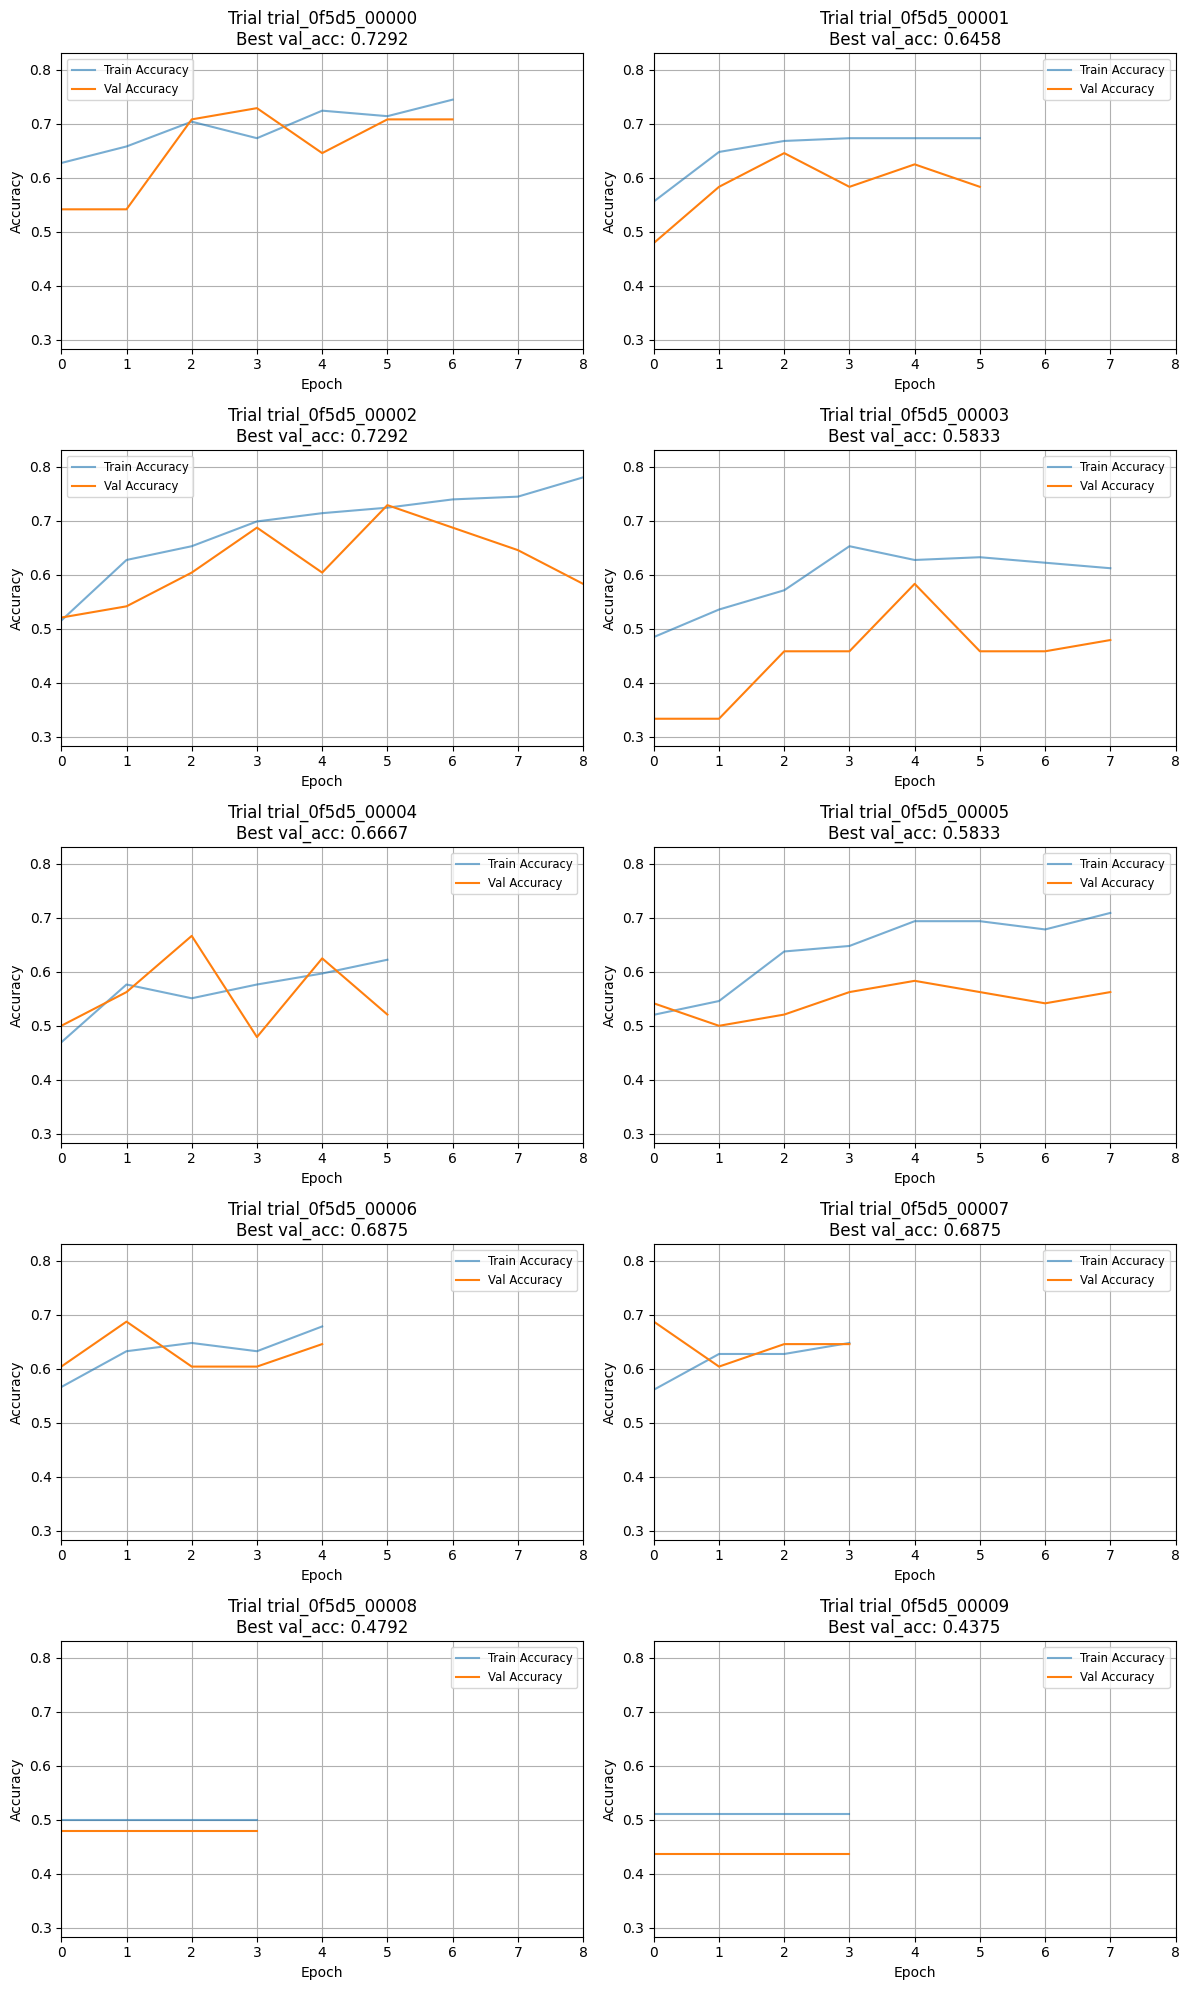

Beste trial: ..\4-hypertuning-ray\ray_results\train_ray_2025-10-19_14-49-32\trial_0f5d5_00000 met val_accuracy = 0.7292


In [41]:
results_dir = Path("..") / "4-hypertuning-ray" / "ray_results" / "train_ray_2025-10-19_14-49-32"
experiment_dir = results_dir
plot_trials_separately_with_equal_axes(experiment_dir)

In [42]:
analysis = ExperimentAnalysis(str(results_dir.resolve()))

df = analysis.dataframe()
filtered_df = df[df["logdir"] == "0f5d5_00000"]
if not filtered_df.empty:
    row = filtered_df.iloc[0]  # pak eerste (en enige) rij als Series
    for col, val in row.items():
        print(f"{col}: {val}")
else:
    print("Geen rijen gevonden met die logdir")

patience: 3
Max_epochs: 20
train_loss: 0.5360674249882601
train_accuracy: 0.7448979591836735
val_loss: 0.5634047786394755
val_accuracy: 0.7083333333333334
timestamp: 1760878253
checkpoint_dir_name: None
done: False
training_iteration: 7
trial_id: 0f5d5_00000
date: 2025-10-19_14-50-53
time_this_iter_s: 8.888983249664307
time_total_s: 67.88015627861023
pid: 15620
hostname: LAPTOP-SHCS6ICM
node_ip: 127.0.0.1
time_since_restore: 67.88015627861023
iterations_since_restore: 7
config/filters: 64
config/units1: 64
config/units2: 32
config/dropout_dense_rate: 0.0
config/dropout_conv_rate: 0.0
config/use_batchnorm: True
config/use_maxpooling: True
config/num_blocks: 4
config/lr: 0.001
config/num_classes: 2
config/epochs: 20
config/patience: 3
logdir: 0f5d5_00000


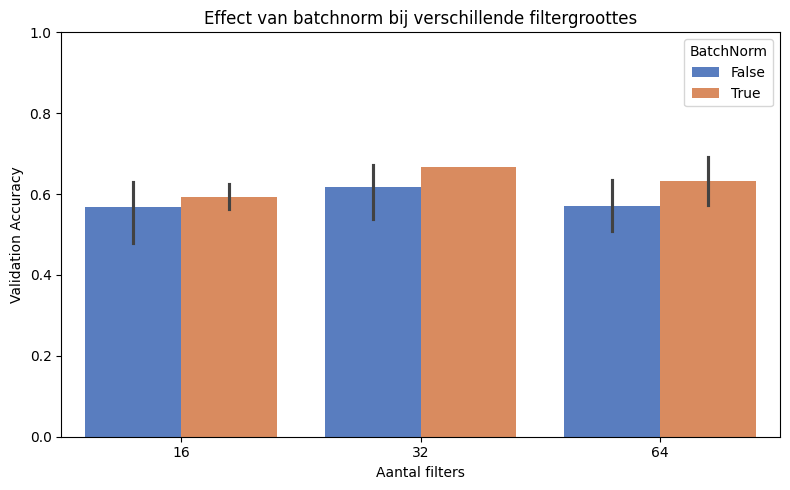

In [50]:
import seaborn as sns
results_dir_41 = Path("..") / "4-hypertuning-ray" / "ray_results" / "train_ray_2025-10-19_14-41-14"
results_dir_49 = Path("..") / "4-hypertuning-ray" / "ray_results" / "train_ray_2025-10-19_14-49-32"
results_dir_48 = Path("..") / "4-hypertuning-ray" / "ray_results" / "train_ray_2025-10-19_15-48-36"

df41= ExperimentAnalysis(str(results_dir_41.resolve())).dataframe()
df49 = ExperimentAnalysis(str(results_dir_49.resolve())).dataframe()
df48 = ExperimentAnalysis(str(results_dir_48.resolve())).dataframe()

combined_df = pd.concat([df41, df49, df48], ignore_index=True)

plt.figure(figsize=(8, 5))
sns.barplot(
    data=combined_df,
    x="config/filters",
    y="val_accuracy",
    hue="config/use_batchnorm",
    palette="muted"
)

# Styling
plt.title("Effect van batchnorm bij verschillende filtergroottes")
plt.ylabel("Validation Accuracy")
plt.xlabel("Aantal filters")
plt.ylim(0.0, 1)  # Pas aan op basis van je data
plt.legend(title="BatchNorm")
plt.tight_layout()
plt.show()


toch nog de patience iets verhogen vermoeden dat die nog steeds niet helemaal is uitgeleerd
#### train 14-50

In [ ]:
config = {
    "filters": 32,
    "units1": {"choice": [64]},
    "units2": {"choice": [32]},
    "dropout_dense_rate": 0.0,
    "dropout_conv_rate": 0.0,
    "use_batchnorm": True,
    "use_maxpooling": True,
    "num_blocks": {"choice": [2, 3, 4, 5]},
    "lr": 1e-3,
    "num_classes": 2,
    "epochs": 20,
    "patience": 5
}
with open("config.json", "w") as f:
    json.dump(config, f)


##### Results

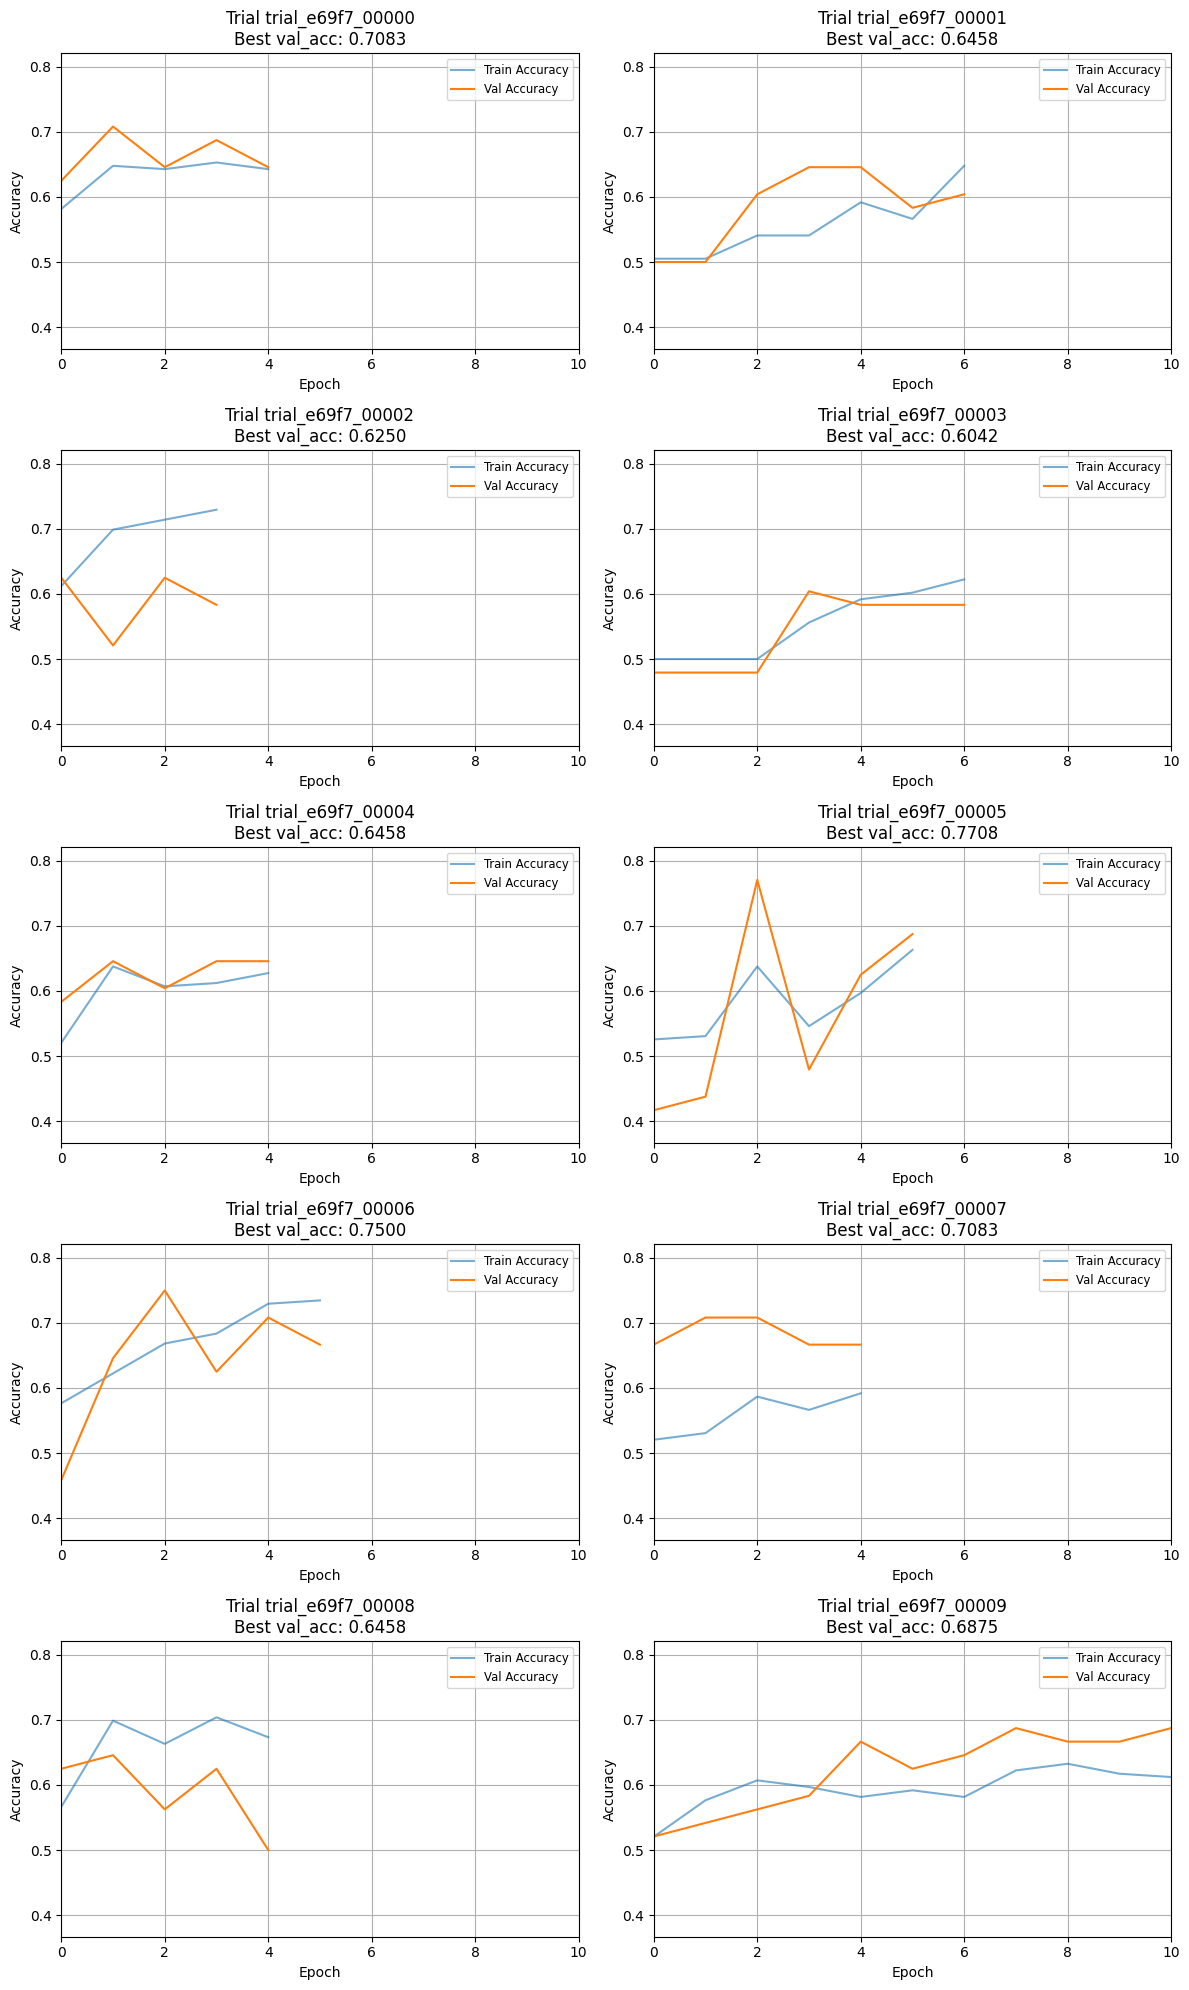

Beste trial: ..\4-hypertuning-ray\ray_results\train_ray_2025-10-19_14-41-14\trial_e69f7_00005 met val_accuracy = 0.7708


In [38]:
experiment_dir = results_dir
plot_trials_separately_with_equal_axes(experiment_dir)

C:\Users\pikob\Documents\GitHub\portfolio-MADS-ML-ElinevDijk\4-hypertuning-ray\scr\ray_results\train_ray_2025-10-18_21-00-23
   train_loss  train_accuracy  val_loss  val_accuracy   timestamp  \
0    0.699257        0.479592  0.681776      0.604167  1760814031   

  checkpoint_dir_name   done  training_iteration     trial_id  \
0                None  False                   1  b38e3_00000   

                  date  ...  config/units1  config/units2  \
0  2025-10-18_21-00-31  ...             16              8   

   config/dropout_dense_rate config/dropout_conv_rate config/use_batchnorm  \
0                   0.018481                 0.005744                False   

   config/use_maxpooling  config/num_blocks  config/lr  config/num_classes  \
0                  False                  1   0.000215                   2   

        logdir  
0  b38e3_00000  

[1 rows x 28 columns]


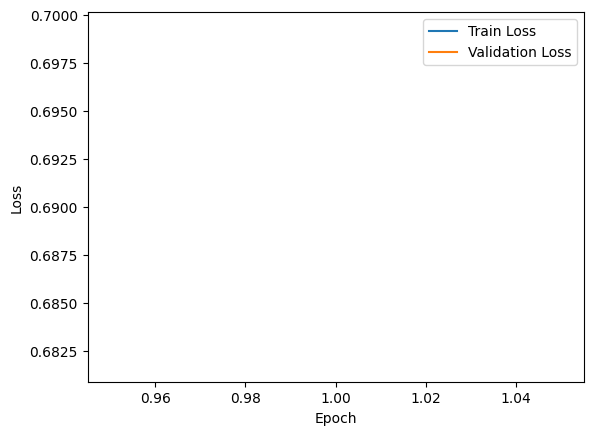

In [ ]:


# Path naar de map met Ray results
from pathlib import Path
results_dir = Path("..") / "4-hypertuning-ray" / "scr" / "ray_results" / "train_ray_2025-10-18_21-00-23"
print(str(results_dir.resolve()))
analysis = ExperimentAnalysis(str(results_dir.resolve()))

df = analysis.dataframe()
print(df.head())


# Visualisatie
plt.plot(df["training_iteration"], df["train_loss"], label="Train Loss")
plt.plot(df["training_iteration"], df["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [12]:
df.training_iteration

0    1
Name: training_iteration, dtype: int64

In [8]:
from pathlib import Path
from ray.tune import ExperimentAnalysis

results_dir = Path("..") / "4-hypertuning-ray" / "scr" / "ray_results" / "train_ray_2025-10-18_21-00-23"
print(results_dir.resolve())  # check het pad
print(results_dir.exists())   # check of hij bestaat

analysis = ExperimentAnalysis(str(results_dir))



C:\Users\pikob\Documents\GitHub\portfolio-MADS-ML-ElinevDijk\4-hypertuning-ray\scr\ray_results\train_ray_2025-10-18_21-00-23
True


ArrowInvalid: URI has empty scheme: '../4-hypertuning-ray/scr/ray_results/train_ray_2025-10-18_21-00-23'